In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import optuna
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./data_try_2.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def optuna_objective(trial):
    gamma=trial.suggest_float('gamma',0.001,0.4)
    C=trial.suggest_int('C',50,150,1)
    epsilon=trial.suggest_float('espilon',0.001,1)
    reg=SVR(gamma=gamma,C=C,epsilon=epsilon)
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [5]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [6]:
optimizer_optuna(500)

[I 2023-05-01 13:23:13,227] A new study created in memory with name: no-name-bcc3386a-e9a5-4daa-a8d8-5ad3a2131b36
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-05-01 13:23:13,278] Trial 0 finished with value: 0.3179326421283545 and parameters: {'gamma': 0.1996489874167533, 'C': 68, 'espilon': 0.8300463777338434}. Best is trial 0 with value: 0.3179326421283545.
[I 2023-05-01 13:23:13,306] Trial 1 finished with value: 0.3179326421283545 and parameters: {'gamma': 0.01550741522584418, 'C': 133, 'espilon': 0.7172489625053579}. Best is trial 0 with value: 0.3179326421283545.
[I 2023-05-01 13:23:13,344] Trial 2 finished with value: 0.6673349233417598 and parameters: {'gamma': 0.1338242639978561, 'C': 71, 'espilon': 0.386425839281055}. Best is trial 2 with value: 0.6673349233417598.
[I 2023-05-01 13:23:13,373] Trial 3 finished with value: 0.3179326421283545 and parameters: {'gamma': 0.06508881853668415, 'C': 60, 'espilon': 0.865766808100042}. Best is trial 2 with value: 0.6673349233417598.
[I 2023-05-01 13:23:13,395] Trial 4 finished with value: 0.6366952167179819 and parameters: {'gamma': 0.3938705165947455, 'C': 143, 'espilon': 0.4036767439

({'gamma': 0.00851574689854894, 'C': 55, 'espilon': 0.05311855740607304},
 [0.8407936882551734])

In [7]:
model = SVR(gamma= 0.017019327295877386,C=65,epsilon=0.001155415652530134).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6744715587109993
rmse: 0.18341481970744664


In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.782923976904242
MAE: 0.11680997198249655
测试集得分为： 0.6812124798571715 0.16129941172654486


In [9]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [10]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

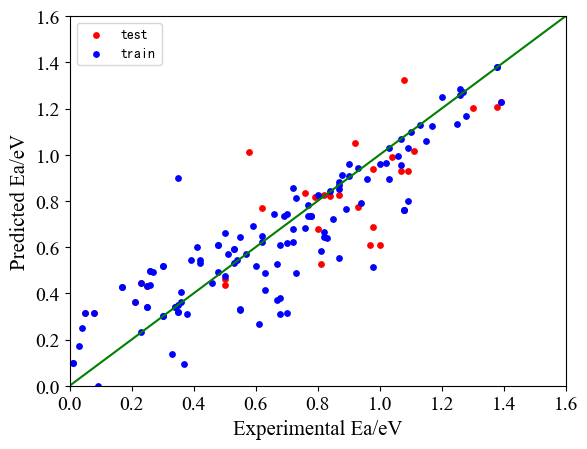

In [11]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
# plt.text(40,92,'Ridge',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

In [12]:
# shap提高解释性
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)
shap.plots.waterfall(shap_values[5], max_display=20)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVR(C=65, epsilon=0.001155415652530134, gamma=0.017019327295877386)